In [1]:
# Импорты нужных библиотек и функций
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.weightstats import ztest
from datetime import datetime

In [2]:
#Читаем таблицу с данными теста
ab_test_groups = pd.read_csv('ab_test_groups.csv')
ab_test_groups.head()

,user_id,grp,ab_test_id
0,1,B,132
1,2,A,132
2,3,B,132
3,4,A,132
4,5,B,132


In [3]:
#Выбираем id 132 (по заданию)
ab_test_groups=ab_test_groups[ab_test_groups['ab_test_id']==127]
ab_test_groups.head()

,user_id,grp,ab_test_id
11999,1,B,127
12000,2,B,127
12001,3,B,127
12002,4,B,127
12003,5,A,127


In [4]:
#Читаем таблицу с данными об оплатах 
payments=pd.read_csv('payments.csv')
# Выбираем нужные данные: нам нужны только столбцы user_id и price. И даты проведения теста: с 2019-08-05 до 2019-08-11
payments=payments.loc[(payments.created_at.astype(str)>='2019-08-05')
                 & (payments.created_at.astype(str)<'2019-08-12'),['user_id','price']]
#Т.к у одно пользлвателя может быть больше одной покупки, мы сгруппируем таблицу по user_id
payments=payments.groupby(['user_id'])['price'].sum()
payments

user_id
1         140.0
10        140.0
23        140.0
24        700.0
39        140.0
          ...  
153184    140.0
153190    140.0
153205    140.0
153212    700.0
153215    140.0
Name: price, Length: 13706, dtype: float64

In [5]:
#Соединим получившиеся таблицы
ab_data=ab_test_groups.merge(payments, on='user_id', how='left')
ab_data

,user_id,grp,ab_test_id,price
0,1,B,127,140.0
1,2,B,127,NaN
2,3,B,127,NaN
3,4,B,127,NaN
4,5,A,127,NaN
...,...,...,...,...
153227,153228,A,127,NaN
153228,153229,B,127,NaN
153229,153230,B,127,NaN
153230,153231,B,127,NaN


In [6]:
#Сгруппируем данные по группе и посмотрим сколько пользователей в каждой из них что-то купило:
ab_summary=ab_data.groupby(['grp']).count()[['user_id','price']]
ab_summary.rename(columns={'user_id':'user_count','price':'buyers_count'}, inplace=True)
display(ab_summary)

,user_count,buyers_count
grp,,
A,76605,4279
B,76627,9427


In [7]:
#Посчитаем долю пользователей в группе 
ab_summary[ab_summary.index=='A']['user_count']/ab_summary['user_count'].sum()*100

grp
A    49.992821
Name: user_count, dtype: float64

In [8]:
#Постичтаем конверисю из пользователя в покупателя
ab_summary['convertion']=ab_summary['buyers_count']/ab_summary['user_count']
ab_summary

,user_count,buyers_count,convertion
grp,,,
A,76605,4279,0.055858
B,76627,9427,0.123025


In [9]:
#Посчитаем средний чек
ab_summary = ab_summary.merge(ab_data.groupby('grp').agg({'price':'mean'}).rename(columns = {'price':'avg_bill'}), 
                 left_index = True, right_index = True) #Сделали агрегацию и прикрепили её к ab_summary
ab_summary

,user_count,buyers_count,convertion,avg_bill
grp,,,,
A,76605,4279,0.055858,396.120589
B,76627,9427,0.123025,348.804498


In [10]:
#Постичтаем ARPU
ab_summary = ab_summary.merge(ab_data.groupby('grp').agg({'price':'sum'}).rename(columns = {'price':'revenue'}), 
                 left_index = True, right_index = True) 
ab_summary['ARPU']=ab_summary['revenue']/ab_summary['user_count']
ab_summary['Add_revenue']=ab_summary['user_count']*(ab_summary['ARPU']-ab_summary.loc['A','ARPU'])
ab_summary

,user_count,buyers_count,convertion,avg_bill,revenue,ARPU,Add_revenue
grp,,,,,,,
A,76605,4279,0.055858,396.120589,1695000.0,22.126493,0.000000e+00
B,76627,9427,0.123025,348.804498,3288180.0,42.911506,1.592693e+06


In [11]:
ztest(ab_data.loc[ab_data.grp == 'A', 'price'].apply(lambda x: 1 if pd.notnull(x) else 0),#Конверсии пользователей группы А
     ab_data.loc[ab_data.grp == 'B', 'price'].apply(lambda x: 1 if pd.notnull(x) else 0) #Конверсии пользователей группы B
     ) 

(-46.38627328408593, 0.0)

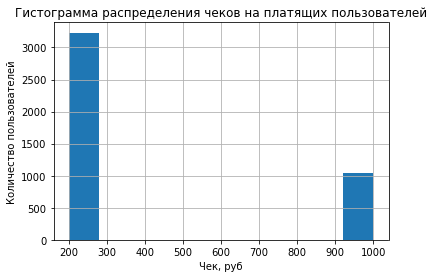

Shapiro-Wilk p-value is 0.0


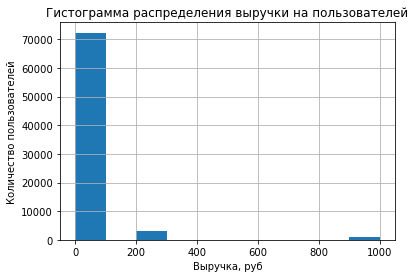

Shapiro-Wilk p-value is 0.0


C:\Users\user\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [12]:
ax = plt.subplot()
ab_data.loc[ab_data.grp == 'A', 'price'].dropna().hist()
ax.set_xlabel('Чек, руб')
ax.set_ylabel('Количество пользователей')
ax.set_title('Гистограмма распределения чеков на платящих пользователей')
plt.show()
print('Shapiro-Wilk p-value is', stats.shapiro(ab_data.loc[ab_data.grp == 'A', 'price'].dropna())[1])

ax = plt.subplot()
ab_data.loc[ab_data.grp == 'A', 'price'].fillna(0).hist()
ax.set_xlabel('Выручка, руб')
ax.set_ylabel('Количество пользователей')
ax.set_title('Гистограмма распределения выручки на пользователей')
plt.show()
print('Shapiro-Wilk p-value is', stats.shapiro(ab_data.loc[ab_data.grp == 'A', 'price'].fillna(0))[1])

In [13]:
# Сравниваем средние чеки
print(stats.mannwhitneyu(ab_data.loc[ab_data.grp == 'A', 'price'].dropna(), ab_data.loc[ab_data.grp == 'B', 'price'].dropna()),
stats.ttest_ind(ab_data.loc[ab_data.grp == 'A', 'price'].dropna(), ab_data.loc[ab_data.grp == 'B', 'price'].dropna())
      , sep = '\n')
#Как мы видим, средние чеки также значимо различаются (так как p-значение << 0.05) по каждому из тестов.

MannwhitneyuResult(statistic=11353450.0, pvalue=0.0)
Ttest_indResult(statistic=8.681488291725874, pvalue=4.342920451712972e-18)


In [14]:
#Сравниваем ARPU
print(stats.mannwhitneyu(ab_data.loc[ab_data.grp == 'A', 'price'].fillna(0), ab_data.loc[ab_data.grp == 'B', 'price'].fillna(0)),
      stats.ttest_ind(ab_data.loc[ab_data.grp == 'A', 'price'].fillna(0), ab_data.loc[ab_data.grp == 'B', 'price'].fillna(0)),
     sep = '\n')

MannwhitneyuResult(statistic=2746687083.0, pvalue=0.0)
Ttest_indResult(statistic=-29.893345238870868, pvalue=8.818064407002295e-196)


In [15]:
#Важные функции для получения доверительных интервалов
def get_conf_interval(data, conf_level = 0.95):  
# Считает доверительные интервалы для средних
        buf = (stats.t.interval(conf_level, len(data),
                             loc=np.mean(data), scale=stats.sem(data)))
        return (buf[1] - buf[0])/2
    
def get_conf_interval_z(succ, tot):  
#Считает доверительные интервалы для бинарных величин
    buf = proportion_confint(succ, tot)
    return buf[1] - buf[0]

In [16]:
get_conf_interval(ab_data.loc[ab_data.grp == 'A', 'price'].fillna(0)) 
#Доверительный полуинтервал для АРПУ пользователей в группе А

0.8641428736438357

In [17]:
#Составляем словарь с доверительными интервалами для каждой метрики и для каждой группы
conf_intervals = {'ARPU':{'A':get_conf_interval(ab_data.loc[ab_data.grp == 'A', 'price'].fillna(0)),
                          'B':get_conf_interval(ab_data.loc[ab_data.grp == 'B', 'price'].fillna(0))},
                  'conversion':{'A':get_conf_interval_z(ab_data.loc[ab_data.grp == 'A', 'price'].dropna().count(),
                                                        ab_data.loc[ab_data.grp == 'A', 'user_id'].count()),
                               'B':get_conf_interval_z(ab_data.loc[ab_data.grp == 'B', 'price'].dropna().count(),
                                                        ab_data.loc[ab_data.grp == 'B', 'user_id'].count())},
                  'avg_bill':{'A':get_conf_interval(ab_data.loc[ab_data.grp == 'A', 'price'].dropna()),
                          'B':get_conf_interval(ab_data.loc[ab_data.grp == 'B', 'price'].dropna())}
                 }
conf_intervals

{'ARPU': {'A': 0.8641428736438357, 'B': 1.0537383983825563},
 'conversion': {'A': 0.0032524511174824022, 'B': 0.004651325604805509},
 'avg_bill': {'A': 10.315428393735829, 'B': 5.467446406040892}}

In [18]:
#Удобная функция для подстановки подписей на barplot
def set_labels(axes):  
#Расставляет подписи столбцов на барплоты
    y0, y1 = axes.get_ybound()  
#Размер графика по оси Y
    y_shift = 0.15* (y1 - y0)  
#Дополнительное место под надписи

    for i, rect in enumerate(axes.patches):  
#По всем нарисованным прямоугольникам
        height = rect.get_height()
        if abs(height) <= 10000:
            label = str(round(height, 2))
            if label[-1] == '0':
                label = label[:-1]
        elif abs(height) <= 1000000:
            label = str(round(height/1000, 1))
            if label[-1] == '0':
                label = label[:-1] + 'k'
            else:
                label = label + 'k'
        else:
            label = str(round(height/1000000, 2))
            if label[-1] == '0':
                label = label[:-1] + 'm'
            else:
                label = label + 'm'
        x = rect.get_x() + rect.get_width() / 2  
#Посередине прямоугольника
        y = height + y_shift * 0.8  
#Над прямоугольником в середине доп. места
        if height < 0:
            y = y_shift * 0.8 
        axes.text(x, y, label, ha='center', va='center', alpha = 0.7)
        axes.set_ybound(y0, y1 + 1.5*y_shift)


In [19]:
plot_summary = ab_summary.T 
#Транспонированная таблица для удобства использования
significant_changes = ['conversion', 'avg_bill'] 
#Метрики со статзначимыми различиями

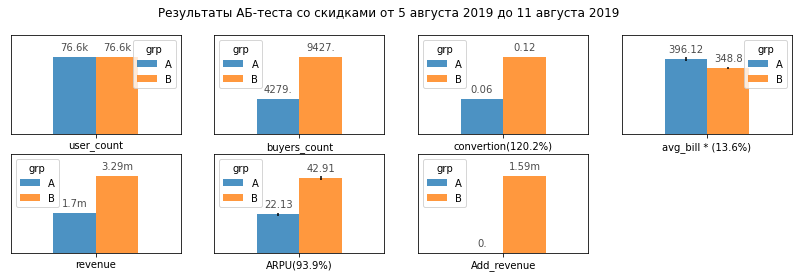

In [20]:
from matplotlib import gridspec
from math import ceil

ax = []
#Массив для складирования графиков
n_pict_in_line = 4
#Количество картинок в одной линии

gs = gridspec.GridSpec(ceil(len(plot_summary) / float(n_pict_in_line)), n_pict_in_line)
#Создаём сетку для графиков
fig = plt.figure(figsize=(n_pict_in_line*3 + 2, ceil(len(plot_summary) / n_pict_in_line) * 2))

##Считаем изменение метрики в процентах
delta_percent = {}
for row in plot_summary.index:  
    if 'user_count' != row and 'buyers_count' != row and 'revenue' != row and "Add_revenue" != row:
        delta_percent[row] = '(' + str(round(plot_summary.loc[row, :].max()/\
                                  plot_summary.loc[row, :].min()*100 - 100, 1)) + '%)'
        
fig.suptitle('Результаты АБ-теста со скидками от 5 августа 2019 до 11 августа 2019')

##Строим графики
for i, col in enumerate(plot_summary.index):
    ax.append(plt.subplot(gs[i // n_pict_in_line, i % n_pict_in_line]))
#Добавляем subplot в нужную клетку
    plot_summary.loc[[col], :].plot(kind='bar', rot=0, ax=ax[i], alpha=0.8,
#Строим график в нужной клетке
                                   yerr=conf_intervals[col] if col in conf_intervals else 0) 
#Редактируем подпись к графику, чтобы в ней хранилась информация о значимости различий 
    stars = ' * ' if col in significant_changes else '' 
    ticks = ax[-1].get_xticklabels()
    ticks[0] = col + stars + delta_percent[col] if col in delta_percent else col + stars
    ax[-1].set_xticklabels(ticks)
    ax[-1].set_yticks([])
    set_labels(axes=ax[i])

## Выводы
1. Тест значимо увеличил ARPU на 94% 
2. Тест значимо увеличил конверсию на 120% верно 
3. Тест значимо уменьшил средний чек на 13,6%  

## Рекомендации
Скидки способствуют мгновенному увеличению выручки, поэтому их можно проводить время от времени. 